### This script shows a basic example of training a SentenceTransformer multimodal model with omics data stored in anndata format

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from mmcontext.utils import setup_logging

setup_logging()

<RootLogger root (INFO)>

In [56]:
from mmcontext.models.mmcontextencoder_old import MMContextEncoder_old

model = MMContextEncoder_old(
    text_encoder_name="pritamdeka/S-BioBert-snli-multinli-stsb",
    omics_input_dim=512,
    processor_obsm_key="X_geneformer",
    freeze_text_encoder=True,
    unfreeze_last_n_layers=1,
    adapter_hidden_dim=512,
    adapter_output_dim=1024,
)

2025-04-24 09:00:50,215 - mmcontext.models.MMContextProcessor_old - INFO - Initialized PrecomputedProcessor. Retrieval mode: numpy. Metadata from AnnData obsm_key: X_geneformer. 


In [57]:
from sentence_transformers import SentenceTransformer

modules = [model]
model = SentenceTransformer(modules=modules)

2025-04-24 09:01:22,997 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


In [61]:
from datasets import load_dataset

dataset_type = "multiplets"
caption_type = "natural_language_annotation"
# data_rep_type = "cell_sentence"
dataset_name = f"cellxgene_pseudo_bulk_3_5k_{dataset_type}_{caption_type}"
dataset = load_dataset(f"jo-mengr/{dataset_name}")
# test_dataset = load_dataset("jo-mengr/human_pancreas_norm_complexBatch_single")

KeyboardInterrupt: 

In [60]:
from datasets.utils.logging import set_verbosity

set_verbosity("DEBUG")  # prints every HTTP call + cache hit

In [47]:
from mmcontext.callback import UnfreezeTextEncoderCallback

# Define the callback (unfreeze after, e.g., 0.5 epochs)
unfreeze_callback = UnfreezeTextEncoderCallback(unfreeze_epoch=0.03)

In [48]:
train_dataset = dataset["train"]
eval_dataset = dataset["val"]

In [50]:
# drop the sample_idx column
# train_dataset = train_dataset.remove_columns("sample_idx")
# eval_dataset = eval_dataset.remove_columns("sample_idx")


In [51]:
from mmcontext.utils import get_evaluator, get_loss

loss = get_loss(dataset_type=dataset_type)
loss = loss(model)
dev_evaluator = get_evaluator(dataset_type=dataset_type, dataset=eval_dataset)
dev_evaluator(model)

ValueError: Dataset for 'multiplets' evaluator must contain keys: {'negative_1', 'positive', 'anchor'}

In [52]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Create optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
train_batch_size = 128  # Your training batch size
num_epochs = 2  # Your number of epochs
total_training_steps = int(len(train_dataset) / train_batch_size * num_epochs)
# Create learning rate scheduler
warmup_steps = int(total_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_training_steps
)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [53]:
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerModelCardData,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.training_args import BatchSamplers

# 3. Load a dataset to finetune on

# test_dataset = test_dataset["train"]
# 5. (Optional) Specify training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="../../data/models/mmcontext_trained",
    # Optional training parameters:
    num_train_epochs=num_epochs,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    # batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name="mmcontext",  # Will be used in W&B if `wandb` is installed
)

# 6. (Optional) Create an evaluator & evaluate the base model
# dev_evaluator = BinaryClassificationEvaluator(
#    sentences1=eval_dataset["anndata_ref"],
#    sentences2=eval_dataset["caption"],
#    labels=eval_dataset["label"],
# )
# dev_evaluator(model)

# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=dev_evaluator,
    # callbacks=[unfreeze_callback],
    # optimizers=(optimizer, scheduler),
)
trainer.train()

## (Optional) Evaluate the trained model on the test set
# test_evaluator = TripletEvaluator(
#    anchors=test_dataset["anchor"],
#    positives=test_dataset["positive"],
#    negatives=test_dataset["negative"],
#    name="all-nli-test",
# )
# test_evaluator(model)

## 8. Save the trained model
# model.save_pretrained("models/mpnet-base-all-nli-triplet/final")

# 9. (Optional) Push it to the Hugging Face Hub
# model.push_to_hub("mpnet-base-all-nli-triplet")



  0%|          | 0/3218 [00:00<?, ?it/s]2025-04-23 14:35:05,745 - mmcontext.models.MMContextProcessor - INFO - Downloading file from share link: https://nxc-fredato.imbi.uni-freiburg.de/s/TzdYndor84D9JMC/download to /var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/2327b065ed846896890bb944f16f86dd.npz
2025-04-23 14:35:09,846 - mmcontext.file_utils - INFO - File is a valid .npz file.
  3%|▎         | 100/3218 [00:28<10:16,  5.06it/s]2025-04-23 14:35:34,736 - mmcontext.models.MMContextProcessor - INFO - Downloading file from share link: https://nxc-fredato.imbi.uni-freiburg.de/s/KFyH77D3oFL6k2r/download to /var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/55bf768e8d1ccd38728d33b8fe3b7bc0.npz


{'loss': 9.4178, 'grad_norm': 27.60757827758789, 'learning_rate': 6.2111801242236025e-06, 'epoch': 0.06}


2025-04-23 14:35:35,642 - mmcontext.file_utils - INFO - File is a valid .npz file.
2025-04-23 14:35:48,033 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.062150403977625855 after 100 steps:
2025-04-23 14:35:49,466 - sentence_transformers.SentenceTransformer - WARNING - `SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.
2025-04-23 14:36:54,764 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             54.53	(Threshold: 0.1583)
2025-04-23 14:36:54,764 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.1925)
2025-04-23 14:36:54,765 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 14:36:54,765 - sentence_transf

{'eval_loss': 10.175690650939941, 'eval_cosine_accuracy': 0.5453296703296703, 'eval_cosine_accuracy_threshold': 0.15825176239013672, 'eval_cosine_f1': 0.6668702290076336, 'eval_cosine_f1_threshold': -0.19250816106796265, 'eval_cosine_precision': 0.5002290426019239, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5122659934397669, 'eval_cosine_mcc': 0.02140292512363475, 'eval_runtime': 80.0328, 'eval_samples_per_second': 20.204, 'eval_steps_per_second': 1.274, 'epoch': 0.06}


  6%|▌         | 200/3218 [02:56<14:25,  3.49it/s]   

{'loss': 7.6897, 'grad_norm': 28.589853286743164, 'learning_rate': 1.2422360248447205e-05, 'epoch': 0.12}


2025-04-23 14:38:12,359 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.12430080795525171 after 200 steps:
2025-04-23 15:17:02,898 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             54.72	(Threshold: 0.2689)
2025-04-23 15:17:02,899 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.2384)
2025-04-23 15:17:02,899 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:17:02,900 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:17:02,900 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    52.38
2025-04-23 15:

{'eval_loss': 7.031648635864258, 'eval_cosine_accuracy': 0.5471611721611722, 'eval_cosine_accuracy_threshold': 0.26894673705101013, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.23838120698928833, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5238162126307143, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 2341.1347, 'eval_samples_per_second': 0.691, 'eval_steps_per_second': 0.044, 'epoch': 0.12}


  9%|▉         | 300/3218 [42:13<08:39,  5.61it/s]     

{'loss': 4.817, 'grad_norm': 19.311508178710938, 'learning_rate': 1.863354037267081e-05, 'epoch': 0.19}


2025-04-23 15:17:30,165 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.18645121193287756 after 300 steps:
2025-04-23 15:17:33,011 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.38	(Threshold: 0.0490)
2025-04-23 15:17:33,012 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.71	(Threshold: -0.4677)
2025-04-23 15:17:33,012 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:17:33,012 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:17:33,013 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.40
2025-04-23 15

{'eval_loss': 3.9910638332366943, 'eval_cosine_accuracy': 0.5238095238095238, 'eval_cosine_accuracy_threshold': 0.04898965358734131, 'eval_cosine_f1': 0.6670739156994502, 'eval_cosine_f1_threshold': -0.4677356481552124, 'eval_cosine_precision': 0.5004582951420715, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5040472392822174, 'eval_cosine_mcc': 0.03027524209883363, 'eval_runtime': 13.6757, 'eval_samples_per_second': 118.239, 'eval_steps_per_second': 7.458, 'epoch': 0.19}


 12%|█▏        | 400/3218 [42:45<08:12,  5.72it/s]  

{'loss': 3.0789, 'grad_norm': 18.126667022705078, 'learning_rate': 1.946132596685083e-05, 'epoch': 0.25}


2025-04-23 15:18:01,995 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.24860161591050342 after 400 steps:
2025-04-23 15:18:04,914 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.33	(Threshold: 0.4303)
2025-04-23 15:18:04,914 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.6126)
2025-04-23 15:18:04,915 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:18:04,915 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:18:04,915 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.34
2025-04-23 15:

{'eval_loss': 2.8833324909210205, 'eval_cosine_accuracy': 0.5132783882783882, 'eval_cosine_accuracy_threshold': 0.4303184449672699, 'eval_cosine_f1': 0.6668704156479217, 'eval_cosine_f1_threshold': -0.6126046180725098, 'eval_cosine_precision': 0.5004587155963303, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5033593744940535, 'eval_cosine_mcc': 0.021417646843905968, 'eval_runtime': 14.136, 'eval_samples_per_second': 114.389, 'eval_steps_per_second': 7.216, 'epoch': 0.25}


 16%|█▌        | 500/3218 [43:17<07:22,  6.14it/s]  

{'loss': 2.3642, 'grad_norm': 13.03532886505127, 'learning_rate': 1.87707182320442e-05, 'epoch': 0.31}


2025-04-23 15:18:35,454 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.3107520198881293 after 500 steps:
2025-04-23 15:18:38,400 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.28	(Threshold: 0.5182)
2025-04-23 15:18:38,400 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.6635)
2025-04-23 15:18:38,401 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:18:38,401 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:18:38,401 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.72
2025-04-23 15:

{'eval_loss': 2.3515050411224365, 'eval_cosine_accuracy': 0.5128205128205128, 'eval_cosine_accuracy_threshold': 0.5181986689567566, 'eval_cosine_f1': 0.6668702290076336, 'eval_cosine_f1_threshold': -0.6634571552276611, 'eval_cosine_precision': 0.5002290426019239, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5072448791308818, 'eval_cosine_mcc': 0.02140292512363475, 'eval_runtime': 14.6773, 'eval_samples_per_second': 110.17, 'eval_steps_per_second': 6.95, 'epoch': 0.31}


 19%|█▊        | 600/3218 [43:49<06:04,  7.19it/s]  

{'loss': 2.035, 'grad_norm': 12.016705513000488, 'learning_rate': 1.808011049723757e-05, 'epoch': 0.37}


2025-04-23 15:19:06,771 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.3729024238657551 after 600 steps:
2025-04-23 15:19:09,789 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.33	(Threshold: 0.4626)
2025-04-23 15:19:09,790 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.6472)
2025-04-23 15:19:09,790 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:19:09,791 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:19:09,791 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    49.68
2025-04-23 15:

{'eval_loss': 2.1550726890563965, 'eval_cosine_accuracy': 0.5132783882783882, 'eval_cosine_accuracy_threshold': 0.46260055899620056, 'eval_cosine_f1': 0.6668702290076336, 'eval_cosine_f1_threshold': -0.6471538543701172, 'eval_cosine_precision': 0.5002290426019239, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.4967676643230505, 'eval_cosine_mcc': 0.02140292512363475, 'eval_runtime': 14.8706, 'eval_samples_per_second': 108.738, 'eval_steps_per_second': 6.859, 'epoch': 0.37}


 22%|██▏       | 700/3218 [44:22<07:44,  5.42it/s]  

{'loss': 1.7631, 'grad_norm': 11.343001365661621, 'learning_rate': 1.738950276243094e-05, 'epoch': 0.44}


2025-04-23 15:19:40,835 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.435052827843381 after 700 steps:
2025-04-23 15:19:44,308 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.28	(Threshold: 0.4648)
2025-04-23 15:19:44,309 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.5425)
2025-04-23 15:19:44,309 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:19:44,310 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:19:44,310 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    49.34
2025-04-23 15:19

{'eval_loss': 1.9621694087982178, 'eval_cosine_accuracy': 0.5128205128205128, 'eval_cosine_accuracy_threshold': 0.4647720456123352, 'eval_cosine_f1': 0.6668704156479217, 'eval_cosine_f1_threshold': -0.5424968600273132, 'eval_cosine_precision': 0.5004587155963303, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.4934157391969316, 'eval_cosine_mcc': 0.021417646843905968, 'eval_runtime': 16.1568, 'eval_samples_per_second': 100.082, 'eval_steps_per_second': 6.313, 'epoch': 0.44}


 25%|██▍       | 800/3218 [44:59<07:14,  5.56it/s]  

{'loss': 1.61, 'grad_norm': 12.944457054138184, 'learning_rate': 1.6698895027624313e-05, 'epoch': 0.5}


2025-04-23 15:20:22,079 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.49720323182100684 after 800 steps:
2025-04-23 15:20:27,868 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.52	(Threshold: -0.2300)
2025-04-23 15:20:27,869 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.6263)
2025-04-23 15:20:27,869 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:20:27,869 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:20:27,870 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    49.87
2025-04-23 15

{'eval_loss': 1.8632291555404663, 'eval_cosine_accuracy': 0.5251831501831502, 'eval_cosine_accuracy_threshold': -0.22996562719345093, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.6262850761413574, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.49870897379485274, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 23.0548, 'eval_samples_per_second': 70.137, 'eval_steps_per_second': 4.424, 'epoch': 0.5}


 28%|██▊       | 900/3218 [45:47<08:36,  4.49it/s]  

{'loss': 1.499, 'grad_norm': 10.221796989440918, 'learning_rate': 1.6008287292817682e-05, 'epoch': 0.56}


2025-04-23 15:21:12,278 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.5593536357986327 after 900 steps:
2025-04-23 15:21:16,616 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.14	(Threshold: 0.4048)
2025-04-23 15:21:16,616 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.6277)
2025-04-23 15:21:16,616 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:21:16,617 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:21:16,617 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.17
2025-04-23 15:2

{'eval_loss': 1.7461304664611816, 'eval_cosine_accuracy': 0.5114468864468864, 'eval_cosine_accuracy_threshold': 0.4047796130180359, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.6276863217353821, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5017165932428548, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 22.9589, 'eval_samples_per_second': 70.43, 'eval_steps_per_second': 4.443, 'epoch': 0.56}


 31%|███       | 1000/3218 [46:32<07:02,  5.24it/s] 

{'loss': 1.5009, 'grad_norm': 15.674149513244629, 'learning_rate': 1.5317679558011052e-05, 'epoch': 0.62}


2025-04-23 15:21:53,692 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.6215040397762586 after 1000 steps:
2025-04-23 15:21:58,571 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.19	(Threshold: 0.4737)
2025-04-23 15:21:58,572 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.5983)
2025-04-23 15:21:58,572 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:21:58,573 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:21:58,573 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.46
2025-04-23 15:

{'eval_loss': 1.7308512926101685, 'eval_cosine_accuracy': 0.5119047619047619, 'eval_cosine_accuracy_threshold': 0.4736976623535156, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.5983315706253052, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5045576388885362, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 20.5599, 'eval_samples_per_second': 78.648, 'eval_steps_per_second': 4.961, 'epoch': 0.62}


 34%|███▍      | 1100/3218 [47:16<09:29,  3.72it/s]  

{'loss': 1.3503, 'grad_norm': 8.24679946899414, 'learning_rate': 1.4627071823204421e-05, 'epoch': 0.68}


2025-04-23 15:22:37,811 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.6836544437538844 after 1100 steps:
2025-04-23 15:22:41,604 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.65	(Threshold: -0.2685)
2025-04-23 15:22:41,605 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.65	(Threshold: -0.5742)
2025-04-23 15:22:41,605 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.09
2025-04-23 15:22:41,605 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.54
2025-04-23 15:22:41,606 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.85
2025-04-23 15

{'eval_loss': 1.6240092515945435, 'eval_cosine_accuracy': 0.5164835164835165, 'eval_cosine_accuracy_threshold': -0.26854407787323, 'eval_cosine_f1': 0.6664622930717352, 'eval_cosine_f1_threshold': -0.5742188096046448, 'eval_cosine_precision': 0.5009216589861751, 'eval_cosine_recall': 0.9954212454212454, 'eval_cosine_ap': 0.5085498510138322, 'eval_cosine_mcc': 0.02294912368292854, 'eval_runtime': 19.2183, 'eval_samples_per_second': 84.138, 'eval_steps_per_second': 5.307, 'epoch': 0.68}


 37%|███▋      | 1200/3218 [47:56<06:02,  5.57it/s]  

{'loss': 1.2944, 'grad_norm': 8.920027732849121, 'learning_rate': 1.3936464088397793e-05, 'epoch': 0.75}


2025-04-23 15:23:16,345 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.7458048477315102 after 1200 steps:
2025-04-23 15:23:20,206 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.74	(Threshold: -0.3427)
2025-04-23 15:23:20,207 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.5775)
2025-04-23 15:23:20,207 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:23:20,208 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:23:20,208 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.16
2025-04-23 15

{'eval_loss': 1.5773476362228394, 'eval_cosine_accuracy': 0.5173992673992674, 'eval_cosine_accuracy_threshold': -0.3427252769470215, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.5774602890014648, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5115714936020255, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 18.246, 'eval_samples_per_second': 88.622, 'eval_steps_per_second': 5.59, 'epoch': 0.75}


 40%|████      | 1300/3218 [48:35<06:39,  4.80it/s]  

{'loss': 1.3323, 'grad_norm': 12.143442153930664, 'learning_rate': 1.3245856353591162e-05, 'epoch': 0.81}


2025-04-23 15:23:56,790 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.8079552517091361 after 1300 steps:
2025-04-23 15:24:00,815 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.11	(Threshold: -0.3243)
2025-04-23 15:24:00,816 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.5799)
2025-04-23 15:24:00,816 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.09
2025-04-23 15:24:00,816 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.73
2025-04-23 15:24:00,817 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.85
2025-04-23 15

{'eval_loss': 1.536850094795227, 'eval_cosine_accuracy': 0.5210622710622711, 'eval_cosine_accuracy_threshold': -0.32430464029312134, 'eval_cosine_f1': 0.666870789957134, 'eval_cosine_f1_threshold': -0.5799389481544495, 'eval_cosine_precision': 0.5009199632014719, 'eval_cosine_recall': 0.9972527472527473, 'eval_cosine_ap': 0.5084528820276274, 'eval_cosine_mcc': 0.02712877736237947, 'eval_runtime': 19.5731, 'eval_samples_per_second': 82.613, 'eval_steps_per_second': 5.211, 'epoch': 0.81}


 44%|████▎     | 1400/3218 [49:14<05:30,  5.49it/s]  

{'loss': 1.2175, 'grad_norm': 12.958115577697754, 'learning_rate': 1.2555248618784532e-05, 'epoch': 0.87}


2025-04-23 15:24:35,580 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.870105655686762 after 1400 steps:
2025-04-23 15:24:39,501 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.20	(Threshold: -0.2393)
2025-04-23 15:24:39,502 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.5564)
2025-04-23 15:24:39,502 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:24:39,503 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:24:39,503 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.70
2025-04-23 15:

{'eval_loss': 1.4984948635101318, 'eval_cosine_accuracy': 0.521978021978022, 'eval_cosine_accuracy_threshold': -0.23927855491638184, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.556430459022522, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5070320245607949, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 18.7743, 'eval_samples_per_second': 86.128, 'eval_steps_per_second': 5.433, 'epoch': 0.87}


 47%|████▋     | 1500/3218 [49:54<05:29,  5.21it/s]  

{'loss': 1.1861, 'grad_norm': 8.982367515563965, 'learning_rate': 1.1864640883977903e-05, 'epoch': 0.93}


2025-04-23 15:25:14,734 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.9322560596643878 after 1500 steps:
2025-04-23 15:25:18,898 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.37	(Threshold: 0.4608)
2025-04-23 15:25:18,899 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.67	(Threshold: -0.5320)
2025-04-23 15:25:18,899 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:25:18,900 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:25:18,900 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.85
2025-04-23 15:

{'eval_loss': 1.4303261041641235, 'eval_cosine_accuracy': 0.5137362637362637, 'eval_cosine_accuracy_threshold': 0.4608227014541626, 'eval_cosine_f1': 0.6666666666666666, 'eval_cosine_f1_threshold': -0.5320340394973755, 'eval_cosine_precision': 0.5002292526364053, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5085384115769996, 'eval_cosine_mcc': 0.012362649025871402, 'eval_runtime': 19.0934, 'eval_samples_per_second': 84.689, 'eval_steps_per_second': 5.342, 'epoch': 0.93}


 50%|████▉     | 1600/3218 [50:34<05:56,  4.54it/s]  

{'loss': 1.1676, 'grad_norm': 8.450663566589355, 'learning_rate': 1.1174033149171271e-05, 'epoch': 0.99}


2025-04-23 15:25:55,072 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.9944064636420137 after 1600 steps:
2025-04-23 15:25:59,723 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.29	(Threshold: -0.2442)
2025-04-23 15:25:59,724 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.65	(Threshold: -0.5258)
2025-04-23 15:25:59,724 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:25:59,725 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.82
2025-04-23 15:25:59,725 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.03
2025-04-23 15

{'eval_loss': 1.4057103395462036, 'eval_cosine_accuracy': 0.5228937728937729, 'eval_cosine_accuracy_threshold': -0.2441575527191162, 'eval_cosine_f1': 0.6664628553959033, 'eval_cosine_f1_threshold': -0.5258466005325317, 'eval_cosine_precision': 0.5002294630564479, 'eval_cosine_recall': 0.9981684981684982, 'eval_cosine_ap': 0.5103363578857382, 'eval_cosine_mcc': 0.009580460457575343, 'eval_runtime': 19.2572, 'eval_samples_per_second': 83.968, 'eval_steps_per_second': 5.297, 'epoch': 0.99}


 53%|█████▎    | 1700/3218 [51:17<05:24,  4.68it/s]  

{'loss': 1.0806, 'grad_norm': 8.837617874145508, 'learning_rate': 1.048342541436464e-05, 'epoch': 1.06}


2025-04-23 15:26:38,766 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.0565568676196395 after 1700 steps:
2025-04-23 15:26:42,943 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.65	(Threshold: -0.2841)
2025-04-23 15:26:42,944 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.67	(Threshold: -0.5245)
2025-04-23 15:26:42,944 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:26:42,945 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.82
2025-04-23 15:26:42,945 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.84
2025-04-23 15

{'eval_loss': 1.3914588689804077, 'eval_cosine_accuracy': 0.5164835164835165, 'eval_cosine_accuracy_threshold': -0.2840782403945923, 'eval_cosine_f1': 0.6666666666666666, 'eval_cosine_f1_threshold': -0.5245093107223511, 'eval_cosine_precision': 0.5004591368227732, 'eval_cosine_recall': 0.9981684981684982, 'eval_cosine_ap': 0.5083502265911544, 'eval_cosine_mcc': 0.01749546270271593, 'eval_runtime': 19.4423, 'eval_samples_per_second': 83.169, 'eval_steps_per_second': 5.246, 'epoch': 1.06}


 56%|█████▌    | 1800/3218 [51:57<04:58,  4.76it/s]  

{'loss': 1.0305, 'grad_norm': 7.211202621459961, 'learning_rate': 9.792817679558012e-06, 'epoch': 1.12}


2025-04-23 15:27:18,229 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.1187072715972655 after 1800 steps:
2025-04-23 15:27:22,217 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             53.16	(Threshold: -0.2472)
2025-04-23 15:27:22,218 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.65	(Threshold: -0.5621)
2025-04-23 15:27:22,218 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.00
2025-04-23 15:27:22,218 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:27:22,219 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.09
2025-04-23 15

{'eval_loss': 1.3639943599700928, 'eval_cosine_accuracy': 0.5315934065934066, 'eval_cosine_accuracy_threshold': -0.24724096059799194, 'eval_cosine_f1': 0.6664630421502749, 'eval_cosine_f1_threshold': -0.5620942115783691, 'eval_cosine_precision': 0.5, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5109150306090109, 'eval_cosine_mcc': 0.0, 'eval_runtime': 18.6673, 'eval_samples_per_second': 86.622, 'eval_steps_per_second': 5.464, 'epoch': 1.12}


 59%|█████▉    | 1900/3218 [52:36<04:45,  4.62it/s]  

{'loss': 1.038, 'grad_norm': 14.324320793151855, 'learning_rate': 9.102209944751383e-06, 'epoch': 1.18}


2025-04-23 15:27:57,517 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.1808576755748912 after 1900 steps:
2025-04-23 15:28:01,240 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             53.07	(Threshold: -0.2280)
2025-04-23 15:28:01,241 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.65	(Threshold: -0.5385)
2025-04-23 15:28:01,241 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.07
2025-04-23 15:28:01,242 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.63
2025-04-23 15:28:01,242 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.21
2025-04-23 15

{'eval_loss': 1.3557878732681274, 'eval_cosine_accuracy': 0.5306776556776557, 'eval_cosine_accuracy_threshold': -0.22801393270492554, 'eval_cosine_f1': 0.6664624808575803, 'eval_cosine_f1_threshold': -0.5385404229164124, 'eval_cosine_precision': 0.5006902899217671, 'eval_cosine_recall': 0.9963369963369964, 'eval_cosine_ap': 0.5120965131929087, 'eval_cosine_mcc': 0.019404169023932726, 'eval_runtime': 18.536, 'eval_samples_per_second': 87.236, 'eval_steps_per_second': 5.503, 'epoch': 1.18}


 62%|██████▏   | 2000/3218 [53:15<04:01,  5.04it/s]  

{'loss': 1.0417, 'grad_norm': 11.535109519958496, 'learning_rate': 8.411602209944753e-06, 'epoch': 1.24}


2025-04-23 15:28:35,957 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.2430080795525171 after 2000 steps:
2025-04-23 15:28:39,864 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.38	(Threshold: -0.2343)
2025-04-23 15:28:39,864 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.67	(Threshold: -0.5046)
2025-04-23 15:28:39,865 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:28:39,865 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:28:39,866 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.97
2025-04-23 15

{'eval_loss': 1.3357161283493042, 'eval_cosine_accuracy': 0.5238095238095238, 'eval_cosine_accuracy_threshold': -0.2343021035194397, 'eval_cosine_f1': 0.6666666666666666, 'eval_cosine_f1_threshold': -0.5045775175094604, 'eval_cosine_precision': 0.5002292526364053, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5097224276588046, 'eval_cosine_mcc': 0.012362649025871402, 'eval_runtime': 18.6489, 'eval_samples_per_second': 86.708, 'eval_steps_per_second': 5.47, 'epoch': 1.24}


 65%|██████▌   | 2100/3218 [53:55<03:27,  5.38it/s]  

{'loss': 1.0277, 'grad_norm': 10.089532852172852, 'learning_rate': 7.720994475138122e-06, 'epoch': 1.31}


2025-04-23 15:29:18,578 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.305158483530143 after 2100 steps:
2025-04-23 15:29:22,744 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             53.02	(Threshold: -0.2540)
2025-04-23 15:29:22,745 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.67	(Threshold: -0.5168)
2025-04-23 15:29:22,745 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:29:22,745 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.82
2025-04-23 15:29:22,746 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.26
2025-04-23 15:

{'eval_loss': 1.309109091758728, 'eval_cosine_accuracy': 0.5302197802197802, 'eval_cosine_accuracy_threshold': -0.2539956569671631, 'eval_cosine_f1': 0.6666666666666666, 'eval_cosine_f1_threshold': -0.5168409943580627, 'eval_cosine_precision': 0.5004591368227732, 'eval_cosine_recall': 0.9981684981684982, 'eval_cosine_ap': 0.5125910958938442, 'eval_cosine_mcc': 0.01749546270271593, 'eval_runtime': 21.2538, 'eval_samples_per_second': 76.081, 'eval_steps_per_second': 4.799, 'epoch': 1.31}


 68%|██████▊   | 2200/3218 [54:37<03:26,  4.93it/s]  

{'loss': 1.047, 'grad_norm': 10.10229778289795, 'learning_rate': 7.030386740331492e-06, 'epoch': 1.37}


2025-04-23 15:29:58,835 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.3673088875077688 after 2200 steps:
2025-04-23 15:30:02,831 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             53.34	(Threshold: -0.2463)
2025-04-23 15:30:02,832 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.71	(Threshold: -0.5191)
2025-04-23 15:30:02,832 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:30:02,833 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:30:02,833 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.28
2025-04-23 1

{'eval_loss': 1.2981489896774292, 'eval_cosine_accuracy': 0.5334249084249084, 'eval_cosine_accuracy_threshold': -0.24634259939193726, 'eval_cosine_f1': 0.6670739156994502, 'eval_cosine_f1_threshold': -0.5191388130187988, 'eval_cosine_precision': 0.5004582951420715, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5127595634427187, 'eval_cosine_mcc': 0.03027524209883363, 'eval_runtime': 19.2821, 'eval_samples_per_second': 83.86, 'eval_steps_per_second': 5.29, 'epoch': 1.37}


 71%|███████▏  | 2300/3218 [55:18<03:06,  4.93it/s]  

{'loss': 0.9919, 'grad_norm': 9.02714729309082, 'learning_rate': 6.339779005524862e-06, 'epoch': 1.43}


2025-04-23 15:30:38,314 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.4294592914853945 after 2300 steps:
2025-04-23 15:30:42,377 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.43	(Threshold: -0.2804)
2025-04-23 15:30:42,377 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.67	(Threshold: -0.5383)
2025-04-23 15:30:42,377 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:30:42,378 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.82
2025-04-23 15:30:42,378 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.20
2025-04-23 15

{'eval_loss': 1.2752593755722046, 'eval_cosine_accuracy': 0.5242673992673993, 'eval_cosine_accuracy_threshold': -0.2803915739059448, 'eval_cosine_f1': 0.6666666666666666, 'eval_cosine_f1_threshold': -0.5382742285728455, 'eval_cosine_precision': 0.5004591368227732, 'eval_cosine_recall': 0.9981684981684982, 'eval_cosine_ap': 0.512034067649214, 'eval_cosine_mcc': 0.01749546270271593, 'eval_runtime': 18.5076, 'eval_samples_per_second': 87.37, 'eval_steps_per_second': 5.511, 'epoch': 1.43}


 75%|███████▍  | 2400/3218 [55:57<02:40,  5.10it/s]  

{'loss': 0.993, 'grad_norm': 10.46475887298584, 'learning_rate': 5.6491712707182325e-06, 'epoch': 1.49}


2025-04-23 15:31:18,397 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.4916096954630205 after 2400 steps:
2025-04-23 15:31:22,299 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.01	(Threshold: -0.2707)
2025-04-23 15:31:22,299 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.5432)
2025-04-23 15:31:22,300 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:31:22,300 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:31:22,300 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.10
2025-04-23 1

{'eval_loss': 1.2600351572036743, 'eval_cosine_accuracy': 0.5201465201465202, 'eval_cosine_accuracy_threshold': -0.2706858515739441, 'eval_cosine_f1': 0.6668702290076336, 'eval_cosine_f1_threshold': -0.5432066917419434, 'eval_cosine_precision': 0.5002290426019239, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5109515947479664, 'eval_cosine_mcc': 0.02140292512363475, 'eval_runtime': 18.5634, 'eval_samples_per_second': 87.107, 'eval_steps_per_second': 5.495, 'epoch': 1.49}


 78%|███████▊  | 2500/3218 [56:38<02:43,  4.39it/s]  

{'loss': 0.9652, 'grad_norm': 9.388802528381348, 'learning_rate': 4.958563535911602e-06, 'epoch': 1.55}


2025-04-23 15:31:59,734 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.5537600994406464 after 2500 steps:
2025-04-23 15:32:03,662 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.97	(Threshold: -0.3037)
2025-04-23 15:32:03,662 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.5641)
2025-04-23 15:32:03,663 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:32:03,663 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:32:03,663 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.13
2025-04-23 1

{'eval_loss': 1.2436474561691284, 'eval_cosine_accuracy': 0.5196886446886447, 'eval_cosine_accuracy_threshold': -0.30371612310409546, 'eval_cosine_f1': 0.6668702290076336, 'eval_cosine_f1_threshold': -0.5640742182731628, 'eval_cosine_precision': 0.5002290426019239, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5113133440267197, 'eval_cosine_mcc': 0.02140292512363475, 'eval_runtime': 19.087, 'eval_samples_per_second': 84.718, 'eval_steps_per_second': 5.344, 'epoch': 1.55}


 81%|████████  | 2600/3218 [57:20<02:21,  4.36it/s]  

{'loss': 0.9809, 'grad_norm': 12.884456634521484, 'learning_rate': 4.2679558011049725e-06, 'epoch': 1.62}


2025-04-23 15:32:41,319 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.6159105034182724 after 2600 steps:
2025-04-23 15:32:45,292 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             53.21	(Threshold: -0.2613)
2025-04-23 15:32:45,293 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.5152)
2025-04-23 15:32:45,293 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.05
2025-04-23 15:32:45,294 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:32:45,294 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.37
2025-04-23 15

{'eval_loss': 1.2415410280227661, 'eval_cosine_accuracy': 0.532051282051282, 'eval_cosine_accuracy_threshold': -0.2613488435745239, 'eval_cosine_f1': 0.6668704156479217, 'eval_cosine_f1_threshold': -0.5152299404144287, 'eval_cosine_precision': 0.5004587155963303, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5136878050633755, 'eval_cosine_mcc': 0.021417646843905968, 'eval_runtime': 18.9884, 'eval_samples_per_second': 85.157, 'eval_steps_per_second': 5.372, 'epoch': 1.62}


 84%|████████▍ | 2700/3218 [58:00<01:31,  5.63it/s]  

{'loss': 0.9871, 'grad_norm': 5.1403632164001465, 'learning_rate': 3.577348066298343e-06, 'epoch': 1.68}


2025-04-23 15:33:21,049 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.678060907395898 after 2700 steps:
2025-04-23 15:33:25,191 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.69	(Threshold: -0.2471)
2025-04-23 15:33:25,192 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.5224)
2025-04-23 15:33:25,192 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:33:25,192 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:33:25,193 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.02
2025-04-23 15:

{'eval_loss': 1.2346423864364624, 'eval_cosine_accuracy': 0.516941391941392, 'eval_cosine_accuracy_threshold': -0.2470797896385193, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.5224310159683228, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5102081253945727, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 19.3671, 'eval_samples_per_second': 83.492, 'eval_steps_per_second': 5.267, 'epoch': 1.68}


 87%|████████▋ | 2800/3218 [58:40<01:22,  5.04it/s]

{'loss': 0.9032, 'grad_norm': 8.978683471679688, 'learning_rate': 2.886740331491713e-06, 'epoch': 1.74}


2025-04-23 15:34:00,709 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.7402113113735238 after 2800 steps:
2025-04-23 15:34:04,436 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.70	(Threshold: -0.2537)
2025-04-23 15:34:04,436 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.67	(Threshold: -0.5138)
2025-04-23 15:34:04,436 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.07
2025-04-23 15:34:04,437 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.73
2025-04-23 15:34:04,437 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.29
2025-04-23 15

{'eval_loss': 1.2302864789962769, 'eval_cosine_accuracy': 0.527014652014652, 'eval_cosine_accuracy_threshold': -0.2536928653717041, 'eval_cosine_f1': 0.6666666666666667, 'eval_cosine_f1_threshold': -0.5138068795204163, 'eval_cosine_precision': 0.5006896551724138, 'eval_cosine_recall': 0.9972527472527473, 'eval_cosine_ap': 0.5129068064541709, 'eval_cosine_mcc': 0.0214422506967559, 'eval_runtime': 18.0976, 'eval_samples_per_second': 89.349, 'eval_steps_per_second': 5.636, 'epoch': 1.74}


 90%|█████████ | 2900/3218 [59:18<01:02,  5.06it/s]

{'loss': 0.9102, 'grad_norm': 9.400627136230469, 'learning_rate': 2.196132596685083e-06, 'epoch': 1.8}


2025-04-23 15:34:38,214 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.8023617153511498 after 2900 steps:
2025-04-23 15:34:41,963 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             51.51	(Threshold: -0.2006)
2025-04-23 15:34:41,964 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.5063)
2025-04-23 15:34:41,964 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:34:41,965 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:34:41,965 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.05
2025-04-23 15

{'eval_loss': 1.2253379821777344, 'eval_cosine_accuracy': 0.5151098901098901, 'eval_cosine_accuracy_threshold': -0.20057255029678345, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.5063459873199463, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5105062548737276, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 17.8331, 'eval_samples_per_second': 90.674, 'eval_steps_per_second': 5.72, 'epoch': 1.8}


 93%|█████████▎| 3000/3218 [59:56<00:42,  5.09it/s]

{'loss': 0.9485, 'grad_norm': 14.672661781311035, 'learning_rate': 1.5055248618784531e-06, 'epoch': 1.86}


2025-04-23 15:35:16,987 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.8645121193287757 after 3000 steps:
2025-04-23 15:35:21,193 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.15	(Threshold: -0.2400)
2025-04-23 15:35:21,193 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.63	(Threshold: -0.5172)
2025-04-23 15:35:21,194 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.98
2025-04-23 15:35:21,194 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.91
2025-04-23 15:35:21,194 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.19
2025-04-23 15

{'eval_loss': 1.2167420387268066, 'eval_cosine_accuracy': 0.5215201465201466, 'eval_cosine_accuracy_threshold': -0.2400110363960266, 'eval_cosine_f1': 0.6662595419847329, 'eval_cosine_f1_threshold': -0.5171517133712769, 'eval_cosine_precision': 0.49977095739807603, 'eval_cosine_recall': 0.9990842490842491, 'eval_cosine_ap': 0.5119201818991603, 'eval_cosine_mcc': -0.02140292512363475, 'eval_runtime': 19.2219, 'eval_samples_per_second': 84.123, 'eval_steps_per_second': 5.306, 'epoch': 1.86}


 96%|█████████▋| 3100/3218 [1:00:35<00:20,  5.67it/s]

{'loss': 0.9061, 'grad_norm': 8.393723487854004, 'learning_rate': 8.149171270718233e-07, 'epoch': 1.93}


2025-04-23 15:35:55,282 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.9266625233064016 after 3100 steps:
2025-04-23 15:35:59,219 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             52.11	(Threshold: -0.2236)
2025-04-23 15:35:59,220 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.69	(Threshold: -0.5387)
2025-04-23 15:35:59,220 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.02
2025-04-23 15:35:59,220 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:35:59,221 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.15
2025-04-23 1

{'eval_loss': 1.2148901224136353, 'eval_cosine_accuracy': 0.5210622710622711, 'eval_cosine_accuracy_threshold': -0.22361719608306885, 'eval_cosine_f1': 0.6668702290076336, 'eval_cosine_f1_threshold': -0.538677990436554, 'eval_cosine_precision': 0.5002290426019239, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5114855073913325, 'eval_cosine_mcc': 0.02140292512363475, 'eval_runtime': 18.388, 'eval_samples_per_second': 87.938, 'eval_steps_per_second': 5.547, 'epoch': 1.93}


 99%|█████████▉| 3200/3218 [1:01:13<00:03,  5.86it/s]

{'loss': 0.9316, 'grad_norm': 5.367766857147217, 'learning_rate': 1.243093922651934e-07, 'epoch': 1.99}


2025-04-23 15:36:33,581 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 1.9888129272840274 after 3200 steps:
2025-04-23 15:36:37,327 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             53.07	(Threshold: -0.2709)
2025-04-23 15:36:37,327 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   66.73	(Threshold: -0.4937)
2025-04-23 15:36:37,328 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            50.07
2025-04-23 15:36:37,328 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               100.00
2025-04-23 15:36:37,328 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    51.68
2025-04-23 1

{'eval_loss': 1.2226964235305786, 'eval_cosine_accuracy': 0.5306776556776557, 'eval_cosine_accuracy_threshold': -0.27085161209106445, 'eval_cosine_f1': 0.6672777268560953, 'eval_cosine_f1_threshold': -0.493679940700531, 'eval_cosine_precision': 0.5006877579092159, 'eval_cosine_recall': 1.0, 'eval_cosine_ap': 0.5168129237108294, 'eval_cosine_mcc': 0.0370879470776142, 'eval_runtime': 17.8403, 'eval_samples_per_second': 90.637, 'eval_steps_per_second': 5.717, 'epoch': 1.99}


100%|██████████| 3218/3218 [1:01:36<00:00,  2.45it/s]2025-04-23 15:36:41,829 - sentence_transformers.trainer - INFO - Saving model checkpoint to ../../data/models/mmcontext_trained/checkpoint-3218
2025-04-23 15:36:41,830 - sentence_transformers.SentenceTransformer - INFO - Save model to ../../data/models/mmcontext_trained/checkpoint-3218
100%|██████████| 3218/3218 [1:01:36<00:00,  1.15s/it]

{'train_runtime': 3696.5215, 'train_samples_per_second': 13.922, 'train_steps_per_second': 0.871, 'train_loss': 1.8414422361801839, 'epoch': 2.0}


TrainOutput(global_step=3218, training_loss=1.8414422361801839, metrics={'train_runtime': 3696.5215, 'train_samples_per_second': 13.922, 'train_steps_per_second': 0.871, 'total_flos': 0.0, 'train_loss': 1.8414422361801839, 'epoch': 2.0})

In [99]:
model[0].processor.omics_processor.clear_cache()

In [100]:
model.push_to_hub("mmcontext-geo7k-cellxgene3.5k-multiplets")

2025-02-19 13:40:44,722 - sentence_transformers.SentenceTransformer - INFO - Save model to /var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/tmpe439ivah


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

'https://huggingface.co/jo-mengr/mmcontext-geo7k-cellxgene3.5k-multiplets/commit/5a203cc8e40bcf57a9a6a26bf6e436f177c62f9e'

In [102]:
from datasets import load_dataset

# test_dataset = load_dataset("jo-mengr/bowel_disease_single")["train"]
dataset_name = "geo_7k_cellxgene_3_5k_multiplets"
test_dataset = load_dataset(f"jo-mengr/{dataset_name}")["val"]

In [103]:
embeddings = model.encode(test_dataset["anndata_ref"])

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [118]:
from mmcontext.utils import load_test_adata_from_hf_dataset

adata = load_test_adata_from_hf_dataset(test_dataset)

2025-02-19 13:45:57,204 - mmcontext.utils - INFO - File is a valid .h5ad file.


In [119]:
adata.obs["_scvi_batch"] = adata.obs["_scvi_batch"].astype("category")

In [105]:
# caption embeddings
text_embeddings = model.encode(adata.obs["natural_language_annotation"].values.tolist())

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [120]:
adata.obsm["mmcontext_emb"] = embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings

2025-02-19 13:46:39,025 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-19 13:46:39,025 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

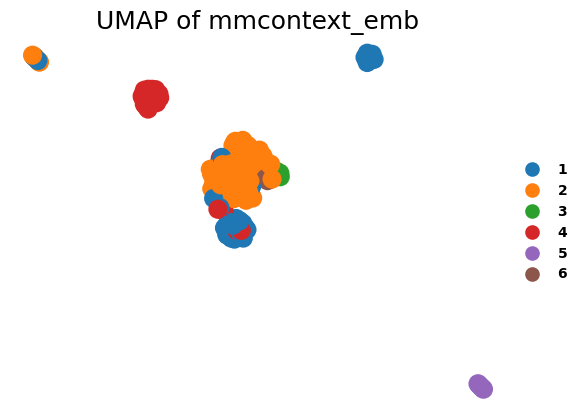

2025-02-19 13:46:39,213 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [124]:
# Visualise the embeddings
from mmcontext.pl import plot_umap
from mmcontext.pp.utils import consolidate_low_frequency_categories

label_key = "_scvi_batch"
adata_cut = consolidate_low_frequency_categories(adata, ["cell_type"], threshold=5, remove=True)
plot_umap(adata_cut, color_key=label_key, embedding_key="mmcontext_emb")

2025-02-19 13:46:44,991 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-19 13:46:44,991 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_text_emb'.


<Figure size 800x800 with 0 Axes>

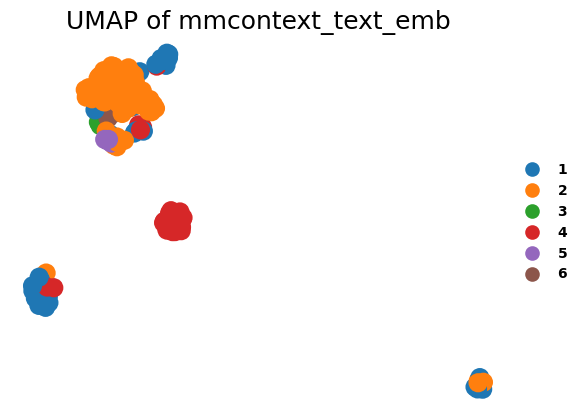

2025-02-19 13:46:45,170 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [125]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

plot_umap(adata, color_key=label_key, embedding_key="mmcontext_text_emb")

In [27]:
labels = adata.obs[label_key].unique().tolist()

In [28]:
from mmcontext.engine import OmicsQueryAnnotator

annotator = OmicsQueryAnnotator(model)
annotator.annotate_omics_data(adata, labels)

2025-02-13 11:18:05,459 - mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]
2025-02-13 11:18:05,603 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-13 11:18:05,603 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-13 11:18:05,604 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu


2025-02-13 11:18:09,497 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-13 11:18:09,497 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
... storing 'best_label' as categorical


<Figure size 800x800 with 0 Axes>

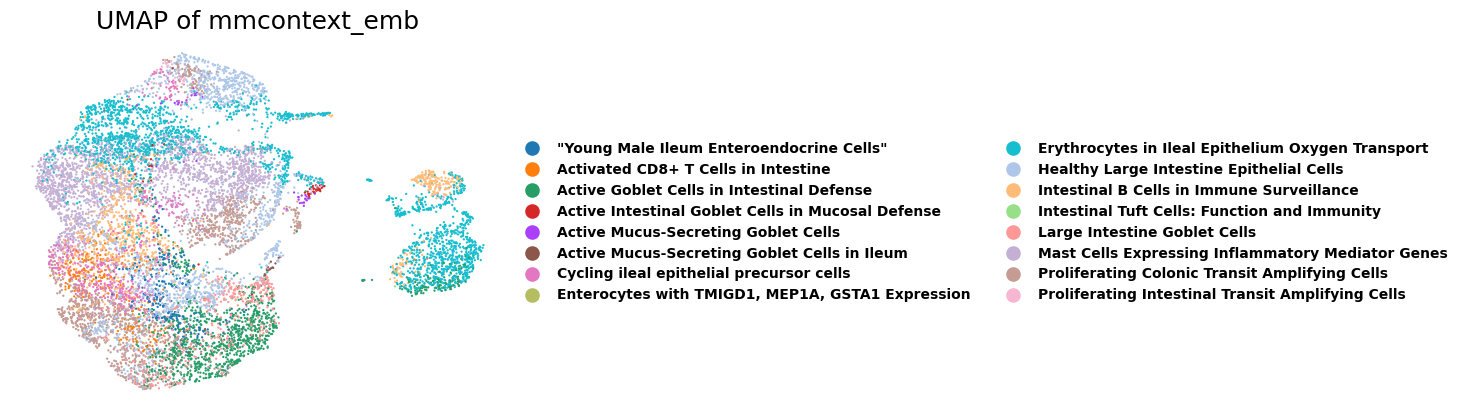

2025-02-13 11:18:13,117 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [29]:
from mmcontext.pl import plot_umap

plot_umap(adata, color_key="best_label", embedding_key="mmcontext_emb")

In [30]:
from mmcontext.eval import evaluate_annotation_accuracy

evaluate_annotation_accuracy(adata, true_key=label_key, inferred_key="best_label")

2025-02-13 11:18:38,032 - mmcontext.eval.annotation_accuracy - INFO - Evaluating annotation accuracy for keys 'cluster_label' and 'best_label'. Accuracy = 4.16%


0.04161073825503356